# Grover's Algorithm with hierarcqal


In [1]:
import sys

sys.path.append("c:\\Users\\Amy\\Desktop\\Green_Git\\hierarqcal")


In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from hierarqcal import Qinit, Qmask, Qunitary, Qpivot, Qcycle, Qunmask


## Background


## Choose the number of qubits

In [3]:
n = 10
random_int = np.random.randint(0, 2**n)
Target_string = bin(random_int)[2:].zfill(n)
N_iterations = 20


In [4]:
print("Number of qubits", n)
print("Number of ancillas", n - 3)
print("Total number of qubits", 2 * (n) - 3)
print("Search space size", 2**n)
print("With target", Target_string)

print("\nInteractions of Grover to perform", N_iterations)
print(
    "Optimal number of iterations",
    int((np.pi / 2 / np.arctan(1 / np.sqrt(2**n)) - 1) / 2),
)


Number of qubits 10
Number of ancillas 7
Total number of qubits 17
Search space size 1024
With target 0011010110

Interactions of Grover to perform 20
Optimal number of iterations 24


## Primitive circuit 


## Create the primitive circuit with Qpivot

In [5]:
# Ration around the zero state but an angle of pi
H = Qunitary("H()^0")
X = Qunitary("X()^0")
H_bottom = Qpivot(mapping=H, global_pattern="*1")
X_i = Qunitary("cp(x)^01", symbols=[np.pi / 2])
X_i_plus_X_j = Qunitary("cnot()^01;cp(x)^12;cnot()^01", symbols=[-np.pi / 2])

U_psi = Qcycle(mapping=H)
U_T = Qpivot(mapping=X, global_pattern=Target_string[::-1])

U_toffoli = Qinit(3)
U_toffoli += H_bottom
U_toffoli += Qpivot(mapping=X_i, global_pattern="*1", merge_within="*1")
U_toffoli += Qpivot(mapping=X_i_plus_X_j, global_pattern="*1", merge_within="*1")
U_toffoli += H_bottom

maskAncillas = Qmask("0" + "01" * (n - 3) + "00")
multiCZ = H_bottom + Qunmask("previous")
multiCZ += Qcycle(mapping=U_toffoli, step=2, boundary="open")
multiCZ += Qmask("*1")
multiCZ += Qcycle(mapping=U_toffoli, step=2, boundary="open", edge_order=[-1])
multiCZ += Qunmask("previous")
multiCZ += maskAncillas + H_bottom

U_reflect_0 = Qcycle(mapping=X) + multiCZ + Qcycle(mapping=X)

U_oracle = U_T + U_reflect_0 + U_T
U_defuse = U_psi + U_reflect_0 + U_psi

ancilla_str = "0" + "01" * (n - 3) + "00"
q_names = [f"q_{i}" if ancilla_str[i] == "0" else f"a_{i}" for i in range(2 * n - 3)]
U = Qinit(q_names) + maskAncillas + U_psi

if N_iterations > 0:
    U += (U_oracle + U_defuse) * N_iterations


In [6]:
# create the circuit using the chose backend
circuit = U(backend="qiskit", barriers=True)
circuit.measure_all()


## Visualize the primitive circuit

Change the value of k to convince yourself that is indeed works as intended.

In [7]:
if N_iterations < 4:
    fig = circuit.draw("mpl", fold=50)
else:
    fig = None

fig


In [8]:
# run the circuit, get counts
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

backend = Aer.get_backend("qasm_simulator")
job = execute(circuit, backend, shots=10000)
result = job.result()
counts = result.get_counts()

# plot_histogram(counts)


In [9]:
Q = []
mask = ["q" if n.split("_")[0] == "q" else "a" for n in q_names]
for k in counts.keys():
    Q.append("".join([k[i] if mask[i] == "q" else "*" for i in range(len(k))]))


In [10]:
counts_q = {}
count_keys = counts.keys()
for x in Q:
    # all binary strings of length n_a
    n_a = len(x.split("*")) - 1
    A = [[x for x in bin(i)[2:].zfill(n_a)] + [""] for i in range(2**n_a)]
    Trace_A = []
    for a in A:
        Trace_A.append("".join([x + y for x, y in zip(x.split("*"), a)]))

    counts_q[x.replace("*", "")] = sum([counts[k] for k in Trace_A if k in count_keys])


Number of qubits 10
Number of ancillas 7
Total number of qubits 17
Search space size 1024
With target 0011010110

Interactions of Grover to perform 20
Optimal number of iterations 24

Top 5 x associate with the 5 larges value of y
['0011010110', '1111011100', '1011100110', '1001111101', '1000101110']
[9190, 4, 4, 4, 4]


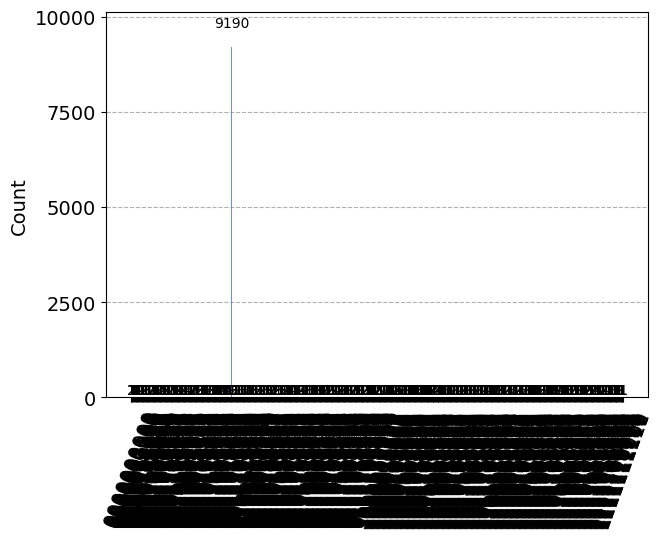

In [11]:
print("Number of qubits", n)
print("Number of ancillas", 2 * (n) - 3 - n)
print("Total number of qubits", 2 * (n) - 3)
print("Search space size", 2**n)
print("With target", Target_string)

print("\nInteractions of Grover to perform", N_iterations)
print("Optimal number of iterations", int((np.pi / 2 * np.sqrt(2**n) - 1) / 2))
print()

x = counts_q.keys()
y = counts_q.values()
# top 5 x associate with the 5 larges value of y
top_x = [x for _, x in sorted(zip(y, x), reverse=True)][:5]
top_y = sorted(y, reverse=True)[:5]

print("Top 5 x associate with the 5 larges value of y")
print(top_x)
print(top_y)

plot_histogram(counts_q)
